In [8]:
import os
import pandas as pd
import numpy as np

# ------------------ CONFIG ------------------
MISSINGNESS_PATH = r"C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_1\data\raw\missingness_summary.xlsx"
SHEET_NAME = "Sheet1" 
OUT_DIR = r"C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_1\outputs\recommendations"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ LOAD ------------------
# This ensures we load exactly one DataFrame
miss_df = pd.read_excel(MISSINGNESS_PATH, sheet_name=SHEET_NAME)


print(pd.ExcelFile(MISSINGNESS_PATH).sheet_names)


['Sheet1']


In [9]:
# Thresholds 
TH_LOW  = 0.20  # <= 20%: MI is comfy
TH_MED  = 0.40  # 20–40%: MI but watch assumptions
TH_HIGH = 0.60  # 40–60%: borderline; only keep if essential

In [10]:
# ------------------ LOAD ------------------

miss_df = pd.read_excel(MISSINGNESS_PATH, sheet_name=SHEET_NAME)
# Try to normalize column names
canon_map = {c.lower().strip(): c for c in miss_df.columns}
def getcol(name):
    for k,v in canon_map.items():
        if k == name:
            return v
    raise KeyError(name)

# Try common variants
col_col = None
for candidate in ["column","variable","Column","Variable","feature","Feature","Column Name"]:
    try:
        col_col = getcol(candidate.lower())
        break
    except KeyError:
        continue

mpct_col = None
for candidate in ["missing_pct","missingness_pct","missing_percent","Missing %","missing_percentage"]:
    if candidate.lower() in canon_map:
        mpct_col = getcol(candidate.lower())
        break
# Fallback: compute from missing_count / n_rows if present
if mpct_col is None and "missing_count" in [c.lower() for c in miss_df.columns]:
    # if you also had n_rows in your overview; if not, we treat it as percent already
    # Here we assume missing_pct is already present; if not, set to np.nan
    pass

if col_col is None:
    raise ValueError("Could not find a 'column' name column in the Missingness summary.")

# Normalize missing_pct to 0..1
missing_pct = miss_df[mpct_col] if mpct_col else None
if missing_pct is not None:
    # If values look like 0..100, convert to fraction
    mx = float(pd.to_numeric(missing_pct, errors="coerce").max())
    if mx > 1.5:  # likely percentages
        miss_df["missing_pct_norm"] = pd.to_numeric(missing_pct, errors="coerce") / 100.0
    else:
        miss_df["missing_pct_norm"] = pd.to_numeric(missing_pct, errors="coerce")
else:
    # If we don't have missing_pct, fill NaN and flag
    miss_df["missing_pct_norm"] = np.nan

miss_df.rename(columns={col_col: "variable"}, inplace=True)
miss_df["variable"] = miss_df["variable"].astype(str)

In [11]:
# ------------------ ROLE + TYPE HEURISTICS ------------------
def guess_type(var):
    v = var.lower()
    if any(k in v for k in ["date","_dt","_date"]):
        return "date"
    if any(k in v for k in ["id","patient_id"]):
        return "id"
    # numeric hints from your dataset
    if any(k in v for k in ["age","bmi","ejection_fraction","_n","_percent","_value","_count"]):
        return "numeric"
    # lab ranges often encoded as categories — treat as categorical unless numeric_derived exists
    if any(k in v for k in ["glucose","white_blood","red_blood","hemoglobin","creatinine","platelet","neutrophil","bilirubin","albumin","ast","alt","azotemia","gamma_gt"]):
        return "categorical_or_range"
    # common categoricals
    if any(k in v for k in ["sex","gender","ethnicity","education","employment","smok","alcohol","stage","grade","genotype","mutation","subtype","location","type","status","category","mode"]):
        return "categorical"
    return "unknown"

# Roles pulled from your proposal priorities
ESSENTIAL_OUTCOMES = {
    # survival
    "death_date", "observation_end_date", "observation_start_date",
    # severe adr flags or grade variables
    "adr_ctcae_grade", "adr_n_grado3", "adr_n_grado4", "adr_n_grado5",
    # hospitalization for readmission proxy (if you operationalize later)
    "hospital_admission_date", "hospital_discharge_date"
}

STRONG_PREDICTORS = {
    # demographics
    "age","age_group","gender","ethnicity","bmi_value","bmi_category",
    # tumor
    "tumor_type","tumor_stage_roman","tumor_stage_tnm","histological_grade",
    "breast_cancer_subtype","colon_cancer_location",
    # treatment
    "oncology_treatment_lines_n","chemo_lines_total_n","chemo_cycles_n",
    "end_reason_progression_any_line","end_reason_toxicity_any_line",
    "dose_reduced","active_principles_n","transfusion_received","transfusions_total_n",
    "prior_radiotherapy","radiotherapy_start_date","radiotherapy_end_date",
    # genetics
    "dpyd_genotype_known","dpyd_genotype_type",
    # labs (as ranges or numeric)
    "blood_glucose_range","white_blood_cells_range","red_blood_cells_range",
    "hemoglobin_range","neutrophils_percent_range","platelet_count_range","creatinine_range",
    "total_bilirubin_range","direct_bilirubin_range","albumin_range","ast_got_range","alt_gpt_range","azotemia_range","gamma_gt_range",
    # cardiac/frailty proxy
    "ejection_fraction_percent","ejection_fraction_category",
    # comorbidity set (all yes/no)
    "hypertension","aortic_insufficiency","dyslipidemia","bph","obesity_comorbidity","ischemic_heart_disease",
    "atrial_fibrillation","copd","asthma","diabetes_type_ii","gastroesophageal_reflux",
    "renal_insufficiency","depressive_syndrome","anemia_comorbidity","psychiatric_disorders",
    "cardiovascular_disorders","gastrointestinal_disorders","cerebrovascular_disorders"
}

def assign_role(var):
    v = var.lower()
    if v in ESSENTIAL_OUTCOMES:
        return "essential_outcome"
    if v in STRONG_PREDICTORS:
        return "strong_predictor"
    if v.endswith("_id") or v == "patient_id":
        return "identifier"
    # dates generally supporting, unless part of outcomes above
    if "date" in v or v.endswith("_dt"):
        return "supporting_date"
    return "supporting"

def priority_from_role(role):
    return {
        "essential_outcome": "high",
        "strong_predictor": "high",
        "supporting_date": "medium",
        "supporting": "low",
        "identifier": "do_not_impute"
    }.get(role, "low")

miss_df["type_guess"] = miss_df["variable"].apply(guess_type)
miss_df["role"] = miss_df["variable"].apply(assign_role)
miss_df["priority"] = miss_df["role"].apply(priority_from_role)

In [12]:
# ------------------ RECOMMENDATIONS ------------------
def recommend_action(miss, role, vtype):
    # Normalize missing to fraction; handle NaN gracefully
    if pd.isna(miss):
        return ("review", "none", "Missing% unknown in summary; verify sheet.")
    # thresholds
    if miss <= TH_LOW:
        if role in ("essential_outcome","strong_predictor"):
            return ("keep_and_impute", "MICE/PMM if numeric; mode if categorical; no-impute for dates", "")
        if role == "supporting_date":
            return ("keep", "no_impute_date (derive durations)", "")
        if role == "identifier":
            return ("keep", "none", "Identifiers should not be imputed.")
        return ("keep", "if used: MI; else none", "")
    elif miss <= TH_MED:
        if role in ("essential_outcome","strong_predictor"):
            return ("keep_and_impute", "MICE/PMM or targeted MI; add missingness_flag if categorical", "Document MAR assumption.")
        if role == "supporting_date":
            return ("keep", "no_impute_date", "")
        return ("consider_keep", "MI if model uses it; else drop", "Depends on predictive utility.")
    elif miss <= TH_HIGH:
        if role in ("essential_outcome","strong_predictor"):
            return ("keep_with_caution", "MICE with strong auxiliaries + missingness_flag", "Add sensitivity analysis.")
        if role == "supporting_date":
            return ("consider_drop", "none", "High missingness in dates; prefer derived intervals from available rows.")
        return ("likely_drop", "none", "Retain only if demonstrated lift.")
    else:  # > TH_HIGH
        if role == "essential_outcome":
            return ("special_handling", "no generic MI", "Attempt targeted recovery or model missingness explicitly (MNAR).")
        if role == "strong_predictor":
            return ("likely_drop_or_flag", "avoid MI unless very strong auxiliaries", "If retained, add missingness indicator; justify clinically.")
        if role == "identifier":
            return ("review_ids", "none", "Investigate why ID is missing.")
        return ("drop", "none", "Too sparse to be reliable.")
    
def imputation_hint(vtype):
    if vtype in ("numeric",):
        return "MICE (PMM) after winsorization"
    if vtype in ("categorical","categorical_or_range"):
        return "Mode; if ordinal, use ordered MI or map to scores + MI"
    if vtype == "date":
        return "Do not impute; derive durations"
    if vtype == "id":
        return "Never impute IDs"
    return "Depends on modeling role"

recs = []
for _, r in miss_df.iterrows():
    var = r["variable"]
    miss = r["missing_pct_norm"]
    vtype = r["type_guess"]
    role  = r["role"]
    action, imp, note = recommend_action(miss, role, vtype)
    # Default imputation method suggestion by type (if not already specific)
    if imp == "none":
        method = "none"
    elif imp.startswith("no_impute"):
        method = "no_impute"
    else:
        method = imputation_hint(vtype) if "MICE" in imp or imp == "" else imp
    recs.append({
        "variable": var,
        "type_guess": vtype,
        "missing_pct": None if pd.isna(miss) else round(100*miss,2),
        "role": role,
        "priority": priority_from_role(role),
        "recommended_action": action,
        "imputation_method": method,
        "notes": note
    })

plan = pd.DataFrame(recs).sort_values(["priority","missing_pct"], ascending=[True, False])

# Friendly ordering by priority (high → low), then missing%
priority_order = {"high":0, "medium":1, "low":2, "do_not_impute":3}
plan["priority_rank"] = plan["priority"].map(priority_order).fillna(9)
plan = plan.sort_values(["priority_rank","missing_pct"], ascending=[True, False]).drop(columns=["priority_rank"])

# ------------------ SAVE ------------------
OUT_XLSX = os.path.join(OUT_DIR, "variable_action_plan.xlsx")
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as w:
    plan.to_excel(w, sheet_name="action_plan", index=False)
    miss_df.sort_values("missing_pct_norm", ascending=False).to_excel(w, sheet_name="raw_missingness", index=False)

print("Action plan saved to:", OUT_XLSX)

# Console summary
to_drop = plan[plan["recommended_action"].isin(["drop","likely_drop","likely_drop_or_flag"])]
to_keep = plan[plan["recommended_action"].isin(["keep_and_impute","keep","keep_with_caution","consider_keep","special_handling"])]
print(f"Suggest drop/flag: {len(to_drop)} | Suggest keep/impute: {len(to_keep)}")


Action plan saved to: C:\Users\HP\OneDrive\Desktop\VERO_code\Phase_1\outputs\recommendations\variable_action_plan.xlsx
Suggest drop/flag: 30 | Suggest keep/impute: 101


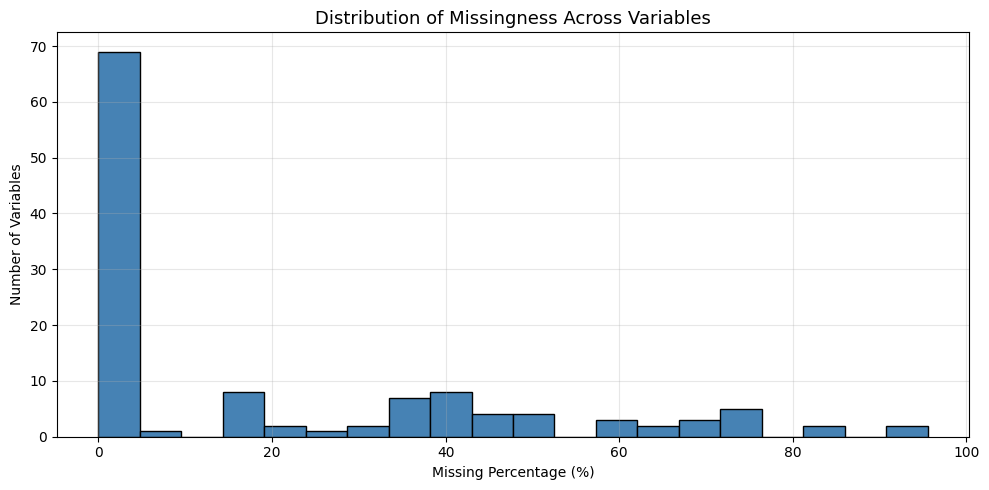

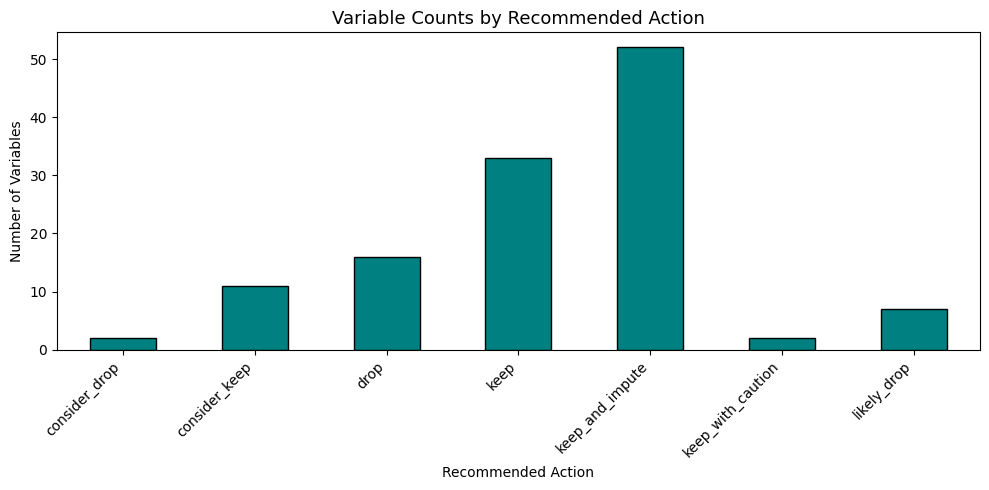

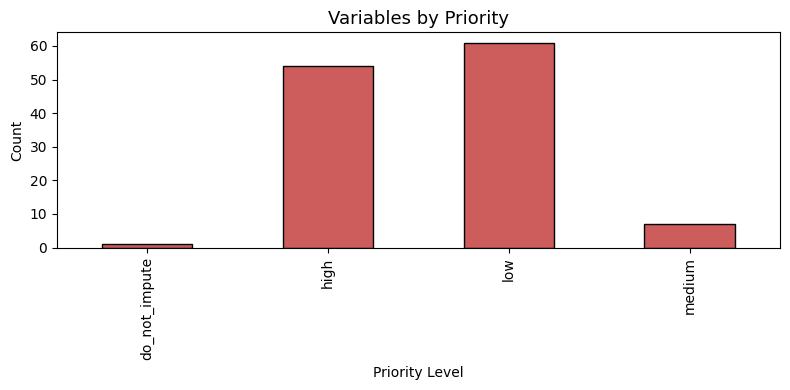

<Figure size 1000x600 with 0 Axes>

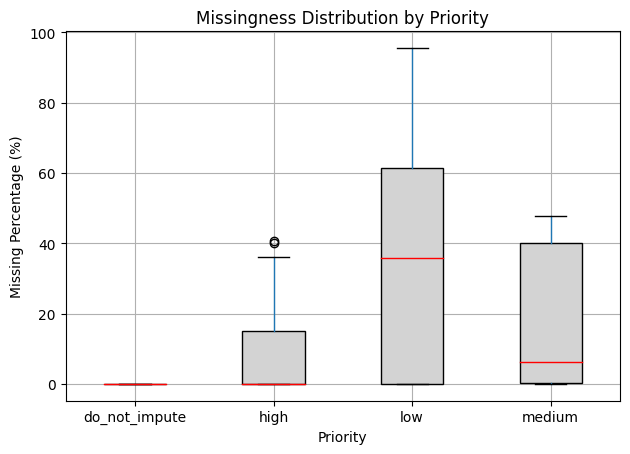

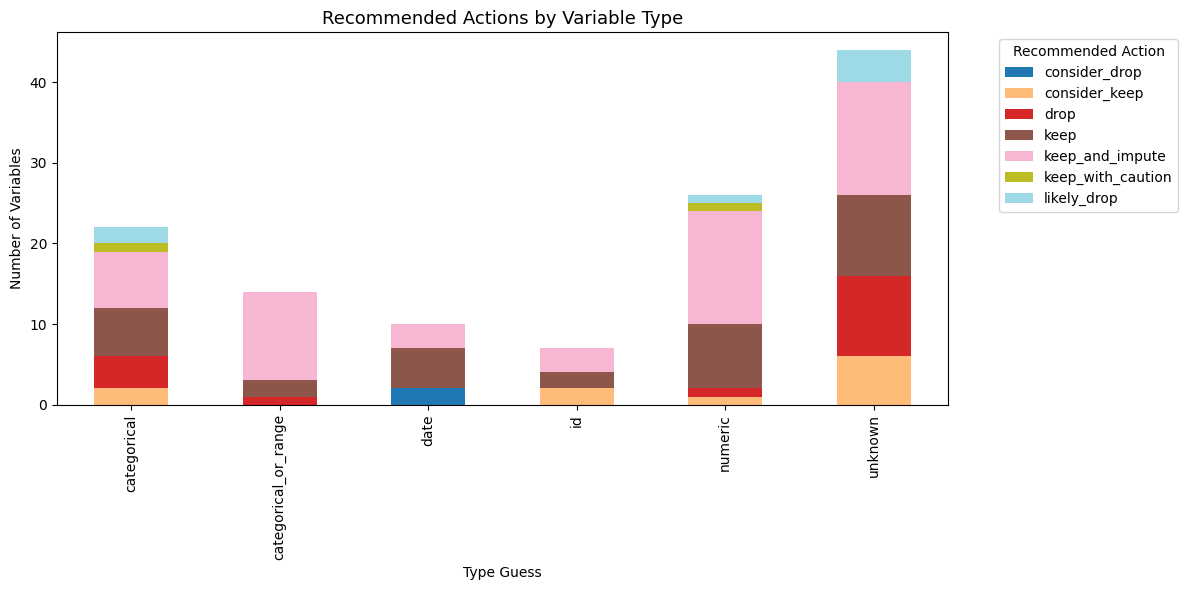

Summary tables saved to: /Users/guidoputignano/PycharmProjects/VERO_code_edit/Phase_1/outputs/summary_tables.xlsx
✅ All plots saved in: /Users/guidoputignano/PycharmProjects/VERO_code_edit/Phase_1/outputs


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- CONFIG ----------
PATH = r"/Users/guidoputignano/PycharmProjects/VERO_code_edit/Phase_1/outputs/recommendations/variable_action_plan.xlsx"
OUT_DIR = r"/Users/guidoputignano/PycharmProjects/VERO_code_edit/Phase_1/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- LOAD ----------
df = pd.read_excel(PATH, sheet_name="action_plan")

# Ensure missing_pct is numeric
df["missing_pct"] = pd.to_numeric(df["missing_pct"], errors="coerce").fillna(0)

# ---------- 1. Overall missingness distribution ----------
plt.figure(figsize=(10, 5))
plt.hist(df["missing_pct"], bins=20, color="steelblue", edgecolor="black")
plt.title("Distribution of Missingness Across Variables", fontsize=13)
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Number of Variables")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "1_missingness_distribution.png"), dpi=300)
plt.show()

# ---------- 2. Count of variables by recommended action ----------
action_counts = df["recommended_action"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
action_counts.plot(kind="bar", color="teal", edgecolor="black")
plt.title("Variable Counts by Recommended Action", fontsize=13)
plt.xlabel("Recommended Action")
plt.ylabel("Number of Variables")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "2_action_counts.png"), dpi=300)
plt.show()

# ---------- 3. Count by priority ----------
priority_counts = df["priority"].value_counts().sort_index()

plt.figure(figsize=(8, 4))
priority_counts.plot(kind="bar", color="indianred", edgecolor="black")
plt.title("Variables by Priority", fontsize=13)
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "3_priority_counts.png"), dpi=300)
plt.show()

# ---------- 4. Missingness by priority ----------
plt.figure(figsize=(10, 6))
df.boxplot(column="missing_pct", by="priority", grid=True, patch_artist=True,
           boxprops=dict(facecolor="lightgray", color="black"),
           medianprops=dict(color="red"))
plt.title("Missingness Distribution by Priority")
plt.suptitle("")
plt.xlabel("Priority")
plt.ylabel("Missing Percentage (%)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "4_missingness_by_priority.png"), dpi=300)
plt.show()

# ---------- 5. Stacked bar: type_guess vs recommended_action ----------
cross_tab = pd.crosstab(df["type_guess"], df["recommended_action"])

cross_tab.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Recommended Actions by Variable Type", fontsize=13)
plt.xlabel("Type Guess")
plt.ylabel("Number of Variables")
plt.legend(title="Recommended Action", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "5_type_vs_action_stacked.png"), dpi=300)
plt.show()

# ---------- 6. Optional: Save summary tables ----------
summary = {
    "By Priority": df["priority"].value_counts(),
    "By Recommended Action": df["recommended_action"].value_counts(),
    "By Type": df["type_guess"].value_counts(),
}
summary_path = os.path.join(OUT_DIR, "summary_tables.xlsx")
with pd.ExcelWriter(summary_path) as writer:
    for name, s in summary.items():
        s.to_excel(writer, sheet_name=name)
print(f"Summary tables saved to: {summary_path}")

print(f"✅ All plots saved in: {OUT_DIR}")


In [11]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]

[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [13]:
cross_tab

recommended_action,consider_drop,consider_keep,drop,keep,keep_and_impute,keep_with_caution,likely_drop
type_guess,,,,,,,
categorical,0,2,4,6,7,1,2
categorical_or_range,0,0,1,2,11,0,0
date,2,0,0,5,3,0,0
id,0,2,0,2,3,0,0
numeric,0,1,1,8,14,1,1
unknown,0,6,10,10,14,0,4


In [14]:
cross_tab = cross_tab.drop('id')

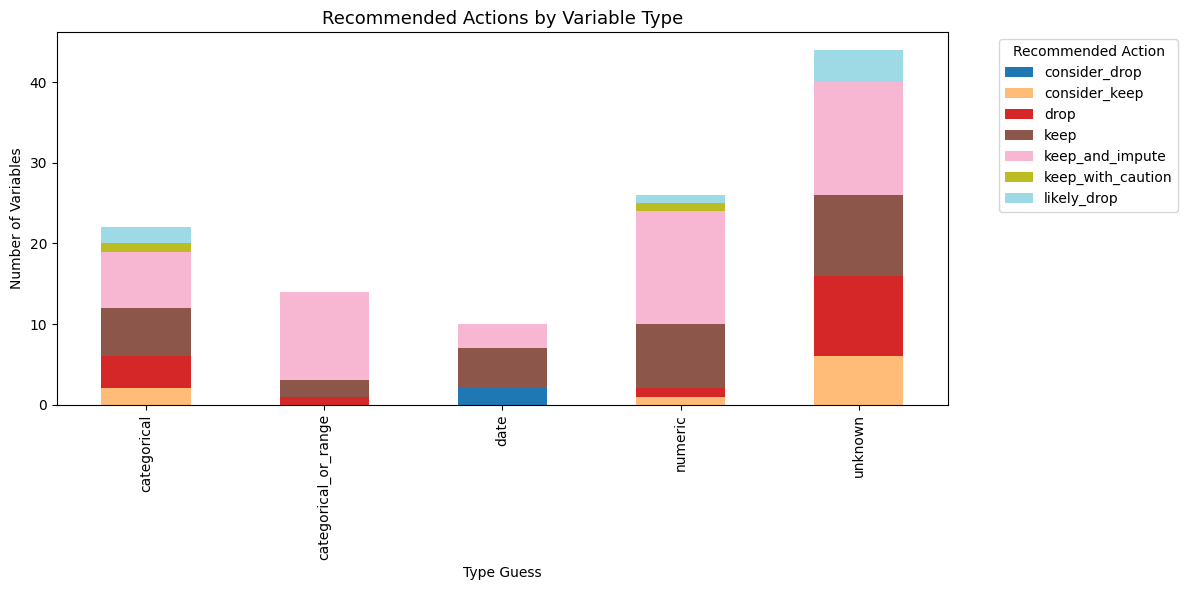

In [15]:
cross_tab.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Recommended Actions by Variable Type", fontsize=13)
plt.xlabel("Type Guess")
plt.ylabel("Number of Variables")
plt.legend(title="Recommended Action", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "5_type_vs_action_stacked.png"), dpi=300)
plt.show()